# Climate Change Analysis 
This is a Data Analysis Notebook to explore the data from [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data/data#) on 
"Climate Change: Earth Surface Temperature Data Exploring global temperatures since 1750". 

**Please give me a star on github if you liked the analysis** 

First you have to download the the data containing the following files: 

- GlobalLandTemperaturesByCity.csv	
- GlobalLandTemperaturesByMajorCity.csv	
- GlobalTemperatures.csv
- GlobalLandTemperaturesByCountry.csv	
- GlobalLandTemperaturesByState.csv

The $CO_2$ Emission data is downloaded from the http://www.globalcarbonatlas.org/en/CO2-emissions . The data period is from 1960 to 2018. 


In [65]:
# Import Libraries 
import numpy as np 
import pandas as pd 
import os 
import glob
import matplotlib.pyplot as plt 
import scipy.stats as stats
from datetime import datetime
import gc
import seaborn as sns
#sns.set(style="darkgrid")
#sns.set_color_codes("pastel")
gc.enable()
from statsmodels.tsa.seasonal import seasonal_decompose
def datetime(x):
    return np.array(x, dtype=np.datetime64)
def runmean(x,N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

np.warnings.filterwarnings('ignore')


def plots_stats(df, city="Hanoi"):
    
    


    df['AverageTemperature'].fillna(df.AverageTemperature.mean(), inplace=True)
    
    df_1800 = df[(datetime(df.dt) > datetime('1810-01-01')) & (datetime(df.dt) < datetime('1910-01-01'))]
    df_1900 = df[(datetime(df.dt) > datetime('1910-01-01'))& (datetime(df.dt) < datetime('2010-01-01'))]
    x_1800_1 = df_1800[df_1800.City == city]
    x_1900_1 = df_1900[df_1900.City == city]
    x_1800 = df_1800[df_1800.City == city].AverageTemperature
    x_1900 = df_1900[df_1900.City == city].AverageTemperature    
    plt.subplot(2, 1,1)
    xx_1800 = seasonal_decompose(x_1800, model='additive',filt=None, period=100)
    plt.plot(datetime(df_1800.dt[xx_1800.trend.index]),xx_1800.trend ,color='blue');
    xx_1900 = seasonal_decompose(x_1900, model='additive',filt=None, period=100)
    plt.plot(datetime(df_1900.dt[xx_1900.trend.index]),xx_1900.trend ,color='red');
    plt.title('Temperature Trend Shift in '+city, fontsize=20)
    #plt.legend()
    plt.subplot(2, 1,2)
    n, x, _ = plt.hist(xx_1800.trend, density=True, alpha=.6, color='blue', label='1810--1910')  
    #plt.plot(x, density(x), alpha=.3, color="blue")
    x1 = x[1:]
    # find the mode of the first histogram

    dx = (x1.max()-x1.min())/20
    maxx = x1[ n == n.max()]-dx
    #
    print(" ------------------------------------------------------------------------------------------- ")


    print(" ------------------------------------------------------------------------------------------- ")
    print("this much of the recent climate is greater than the past climate : ",(xx_1900.trend > maxx[0]).sum() / xx_1900.trend.shape[0])
    print(" ------------------------------------------------------------------------------------------- ")


    
    plt.axvline(x1[ n == n.max()]-dx,color='k')
    n, x, _ = plt.hist(xx_1900.trend, density=True, alpha=.6, color='red', label='1910--2010')  
    plt.legend()
    plt.xlabel('Temperature Trend in degree Celcius', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    #plt.title(city, fontsize=20)
    
    
    plt.show()
    #
    
    

In [2]:
# First see which data are available:
glob.glob('./*.csv')

['./contries_lon_lat.csv',
 './GlobalLandTemperaturesByCountry.csv',
 './export_20200616_0944.csv',
 './capital_europe.csv',
 './GlobalLandTemperaturesByMajorCity.csv',
 './capitals.csv',
 './df_cor.csv',
 './GlobalLandTemperaturesByState.csv',
 './GlobalTemperatures.csv',
 './df_cor_dupli.csv',
 './df_final.csv',
 './GlobalLandTemperaturesByCity.csv']

In [3]:
#read the GlobalLandTemperaturesByCity.csv
temp_land_cities = pd.read_csv('GlobalLandTemperaturesByCity.csv')
#global_t = pd.read_csv('GlobalTemperatures.csv')
# a quick look in the data : 
temp_land_cities.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


## Quality of the data: 
- `AverageTemperature` : has many nans
- `AverageTemperatureUncertainty` : has as many nans as `AverageTemperature` 
- `City` : there are city names happening in other countries 
- `City` : there are more than 1 city with the same name in the same country 
- Not all the cities have the data coverage for the 1810-2010 period

In [4]:
#number of nans in percent:
(temp_land_cities.isnull().sum(axis = 0) / temp_land_cities.shape[0] )*100

dt                               0.000000
AverageTemperature               4.234458
AverageTemperatureUncertainty    4.234458
City                             0.000000
Country                          0.000000
Latitude                         0.000000
Longitude                        0.000000
dtype: float64

In [5]:
# Good to know that there are many countries that have cities with the same name like La Paz in Mexico 
# and La Paz in Bolivia therefore I write a function to get read of this problem 
def correct_cities(df):
   


    df['AverageTemperature'].fillna(df.AverageTemperature.mean(), inplace=True)
    

    import time
    import sys

    toolbar_width = len(set(df.City))

    # setup toolbar
    sys.stdout.write("[%s]" % (" " * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
    dff = df.copy()
    for city in set(df.City):
        dff = dff[dff.City == city]
        if len(set(dff.Country)) > 1 :
    #        
            for con in set(dff.Country):
                #print(city+"_"+con)
                df['City'].loc[(df.City == city) & (df.Country == con)] = city+"_"+con
        sys.stdout.write("-")
        sys.stdout.flush()


    sys.stdout.write("]\n") # this ends the progress bar
    
    return df
                


In [6]:
# This will take 10 minutes to run: 

#df = temp_land_cities.copy()
#df_cor = correct_cities(df)
#df.to_csv('df_cor.csv')


In [7]:
#load the corrected data:
df = pd.read_csv('df_cor.csv')


In [8]:
#check for cities with the same name in the same country:

len(df[(df.City=="Rongcheng") & (df.dt=="1950-01-01") ])

3

In [9]:
df[(df.City=="Rongcheng") & (df.dt=="2000-01-01") ]

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
6406934,6406934,2000-01-01,14.371,0.181,Rongcheng,China,23.31N,116.21E
6409305,6409305,2000-01-01,4.558,0.291,Rongcheng,China,26.52N,103.88E
6411387,6411387,2000-01-01,2.982,0.377,Rongcheng,China,29.74N,112.62E


In [10]:
df[(df.City=="Peoria") & (df.dt=="1950-01-01") ]

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
5782765,5782765,1950-01-01,9.854,0.227,Peoria,United States,32.95N,112.02W
5786004,5786004,1950-01-01,-1.695,0.292,Peoria,United States,40.99N,89.47W


In [11]:
df[(df.City=="León_Mexico") & (df.dt=="2000-01-01") ]

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
4177060,4177060,2000-01-01,13.442,0.387,León_Mexico,Mexico,21.70N,101.25W


### It is crazy! there are countries that have more than 1 city with the same name!


In [13]:
# Now try to rename such cities: 
df_data = pd.read_csv('df_cor.csv')
import time 
#from multiprocessing import Pool
#pool = Pool(4)
city_multi = []
def correct_city_duplicate(df): 
    df1 = df.copy()
    #for city in set(df.City):
    for kk in range(len(set(df.City))):
        #dff = df.copy()
        city = list(set(df.City))[kk]
        dff = df[df.City == city]
        lenn = len(dff[(dff.City==city) & (dff.dt=="1900-01-01") ])
        
        #print(lenn, city)
        if lenn > 1 :
            
            #print(set(dff.Longitude.values))
#            for k in range(lenn):
#                #print(k,city,lonnn)
#                lonnn = list(set(dff.Longitude.values))[k]
#                lattt = list(set(dff.Longitude.values))[k]
#                #print(df1['City'].loc[(df1.City == city) & (df1.Longitude.values == lonnn )])
#                df1['City'].loc[(df1.City == city) & (df1.Longitude.values == lonnn)] = city+"_"+str(lonnn)+"_"+str(lattt)
#                #print(df1['City'].loc[(df1.City == city) & (df1.Longitude.values == lonnn)])
#                #print(lonnn)
#                #print(set(df1['City'].loc[(df1.City == city+"_"+str(lonnn)+"_"+str(lattt)) & (df1.Longitude.values == lonnn)]))
            print('-----------'+city+'--------------')
            city_multi.append(city)
            

    #del dff, lenn, k, kk
    #return df1 
#    return city_multi
start = time.time()
#df2 = zip(*pool.map(correct_city_duplicate(df_data), range(len(set(df_data)))))


#df2 = correct_city_duplicate(df_data)
print(time.time()-start)
#df2.to_csv('df_cor_dupli.csv')


3.1948089599609375e-05


In [ ]:
#with open("city_multi.txt", "w") as f:
#    for s in df2:
#        f.write(str(s) +"\n")

#with open("city_multi.txt", "r") as f:
#    for line in f:
#        city_m.append(int(line.strip()))

In [ ]:
#city_m = []
#with open("city_multi.txt", "r") as f:
#    for line in f:
#        city_m.append(line.strip())
#d_m = pd.read_csv('df_cor.csv')
#for city in city_m: 
#    print(city)
    
#    lonnn = list(set(d_m[d_m.City == city].Longitude.values))
#    print(lonnn)
#    for lonn in lonnn: 
#        print(lonn)
#        #print(d_m['City'].loc[(d_m.City == city) & (d_m.Longitude.values == lonn )])
#        d_m['City'].loc[(d_m.City == city) & (d_m.Longitude.values == lonn )] = city+"_"+str(lonn)

#d_m.to_csv('df_cor_dupli.csv')

In [14]:
# Now check if it worked: 
df = pd.read_csv('df_cor_dupli.csv')

df[(df.City=="Peoria_112.02W") & (df.dt=="1960-01-01") ]
#df[(df.City=="Peoria_89.47W") & (df.dt=="1950-01-01") ]
#df[(df.City=="Peoria")]

,Unnamed: 0,Unnamed: 0.1,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
5782885,5782885,5782885,1960-01-01,8.487,0.367,Peoria_112.02W,United States,32.95N,112.02W


In [15]:
# Drop the two first columns which are repeatation of the index: 
df.drop(columns=df.columns.values[0:2],inplace=True)

/Users/bijanfallah/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/bijanfallah/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7206005004170142
 ------------------------------------------------------------------------------------------- 


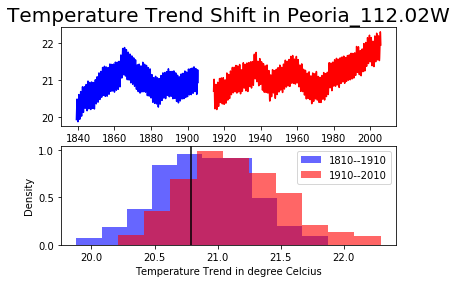

In [16]:
plots_stats(df, city="Peoria_112.02W")

/Users/bijanfallah/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/bijanfallah/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.9057547956630525
 ------------------------------------------------------------------------------------------- 


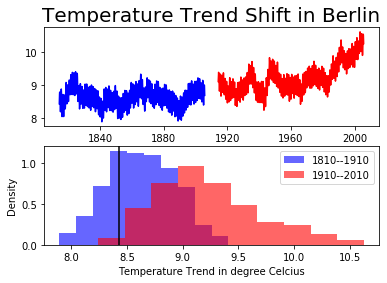

In [17]:
# A test plot for City Berlin 

plots_stats(df, city="Berlin")

## Climate shift: 

As it can be seen in the histograms of the trends for the two climatic period, the more recent one is shifted significantly to the right or warmer climate conditions for Berlin air temperature . Note the white space in the time-series plot (dicontinuity in the time-serie) is comming from filtering approach used. 91% of the new climate data is located to the right side of the climate mode for the 1810-1910 period. Mode is the most frequent temperature in the histogram. One could also use the mean but if you have outliers in the data the mean might be influenced. I will calculate this number (percent of the data located to the right side of the mode for the 1810-1910 period) for all cities around the world! 






## Data Problems when comparing 1810-1910 and 1910-2010 period:

- when calculating the trends, many cities (for example all the Indian cities) will deliver the same trend as the filtering window is large to remove the seasonal frequencies in the temperature data. 

- Many countries have more than one city with the same name! And that will mess up the trend calculation. Look the following chunk: 



In [33]:
# There are 3 cities with the name "Rongcheng" in China!
len(df[(df.City=="León") & (df.dt=="2000-01-01") ])
df['City'].loc[(df.City == "León_Mexico") ]

4175080    León_Mexico
4175081    León_Mexico
4175082    León_Mexico
4175083    León_Mexico
4175084    León_Mexico
              ...     
4177220    León_Mexico
4177221    León_Mexico
4177222    León_Mexico
4177223    León_Mexico
4177224    León_Mexico
Name: City, Length: 2145, dtype: object

And we have to treat it right. The fastest seloution might be to change the city names by adding Latitude and Longitude values to the city names. 


Therefore, I will write the following function to do so: 


In [ ]:
#def correct_city_duplicate(df): 
#    for city in set(df.City):
#        dff = df[df.City == city]
#        lenn = len(dff[(dff.City==city) & (dff.dt=="2000-01-01") ])
#        if lenn > 1 :
#            
#            for k in range(lenn):
#                #print(city+"_"+con)
#                df['City'].loc[(df.City == city) & (df.Longitude == dff.Longitude[k])] = city+"_"+str(dff.Longitude[k])+"_"+str(dff.Latitude[k])
#    return df 


In [34]:
#lets do the diff index to see how much of the recent climate 1910 to 2010 is on the right hand of the 
# past climate mode  (1810-1910)
data_final = pd.DataFrame()
data = []
city_name = []
index= []
lati = []
long = []
k = 0


#df['AverageTemperature'].replace(r'^\s*$', np.nan, regex=True, inplace=True)    
df['AverageTemperature'].fillna(df.AverageTemperature.mean(), inplace=True)

df_1800 = df[(datetime(df.dt) > datetime('1810-01-01')) & (datetime(df.dt) < datetime('1910-01-01'))]
df_1900 = df[(datetime(df.dt) > datetime('1910-01-01')) & (datetime(df.dt) < datetime('2010-01-01'))]


for city in set(df.City) : 
    k+=1
    index.append(k)
    city_name.append(city)
    
    #print(city)
    x_1800 = df_1800[df_1800.City == city].AverageTemperature
    x_1900 = df_1900[df_1900.City == city].AverageTemperature
  


    #print((x_1900.isnull()==False).sum())
    if (x_1900.isnull()==False).sum() < 1000 :
        data.append(float('NaN'))
        long.append(float('NaN'))
        lati.append(float('NaN')) 
        continue
    long.append(df_1800[df_1800.City == city].Longitude.values[0])
    lati.append(df_1800[df_1800.City == city].Latitude.values[0])    
    xx_1800 = seasonal_decompose(x_1800, model='additive',filt=None, period=100)
    #plt.plot(datetime(df_1800.dt[xx_1800.trend.index]),xx_1800.trend ,color='blue');
    xx_1900 = seasonal_decompose(x_1900, model='additive',filt=None, period=100)
    #plt.plot(datetime(df_1900.dt[xx_1900.trend.index]),xx_1900.trend ,color='red');
    n, x = np.histogram(xx_1800.trend[xx_1800.trend.isnull()==False],20)  
    #plt.plot(x, density(x), alpha=.3, color="blue")
    x1 = x[1:]
    # find the mode of the first histogram
    dx = (x1.max()-x1.min())/20
    maxx = x1[ n == n.max()]-dx
    #plt.axvline(x1[ n == n.max()]-dx,color='k')
    n, x = np.histogram(xx_1900.trend[xx_1900.trend.isnull()==False],20)  
    #plt.plot(x, density(x), alpha=.3, color="red")
    
    data.append((xx_1900.trend > maxx[0]).sum() / xx_1900.trend.shape[0])
    
# intialise data of lists. 
datas = {'City':city_name, 'val':data, 'lon':long, 'lat':lati} 
  
# Create DataFrame 
df_final = pd.DataFrame(datas)     



In [35]:
df_final.to_csv('df_trend_diff.csv')

In [ ]:
# there is still some problems with the data as it seems that all indian cities are alike: 
# I test it as follows: 

#just for 100 first :
for i in f[0:30]:
    print(i)
    sit = df_final[(df_final.val > i-.00000001) & (df_final.val < i+.00000001)].City.values
    if len(sit)>1:
    
        print(sit)
        print('---------')

### that must be usuall because they are cities near to each other and show the same warming trends. 


In [36]:
df_final.head()

,City,val,lon,lat
0,Krefeld,0.915763,6.34E,50.63N
1,Ust Ilimsk,0.708924,101.54E,58.66N
2,Bahir Dar,0.914929,37.81E,12.05N
3,Porto,0.808173,8.52W,40.99N
4,Sukabumi,0.916597,106.22E,7.23S


## Now is time for the map plots 


In [39]:
df = pd.read_csv('df_trend_diff.csv')
df.drop(columns=df.columns.values[0],inplace=True)

In [40]:
df.head()

,City,val,lon,lat
0,Krefeld,0.915763,6.34E,50.63N
1,Ust Ilimsk,0.708924,101.54E,58.66N
2,Bahir Dar,0.914929,37.81E,12.05N
3,Porto,0.808173,8.52W,40.99N
4,Sukabumi,0.916597,106.22E,7.23S


In [41]:
for city in df['City']:
    
    if df.loc[df["City"]==city].lon.values[0][-1] == 'E' :
        
        df.loc[df["City"]==city,'lon'] =  df.loc[df["City"]==city].lon.values[0][:-1]
    if df.loc[df["City"]==city].lon.values[0][-1] == 'W' :
        df.loc[df["City"]==city,'lon'] = "-"+df.loc[df["City"]==city].lon.values[0][:-1]
    if df.loc[df["City"]==city].lat.values[0][-1] == 'N' :
        df.loc[df["City"]==city,'lat'] = df.loc[df["City"]==city].lat.values[0][:-1]
    if df.loc[df["City"]==city].lat.values[0][-1] == 'S' :
        df.loc[df["City"]==city,'lat'] = "-"+df.loc[df["City"]==city].lat.values[0][:-1]
    

In [42]:
dff = df.copy()
df.loc[df["City"]=='New York','lon'] 

1550    -74.56
Name: lon, dtype: object

In [43]:
import pandas as pd

import os
os.environ["PROJ_LIB"] = "/Users/bijanfallah/anaconda3/share/proj" 
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt




In [ ]:
#!pip3 install --upgrade matplotlib
#!pip3 install basemap


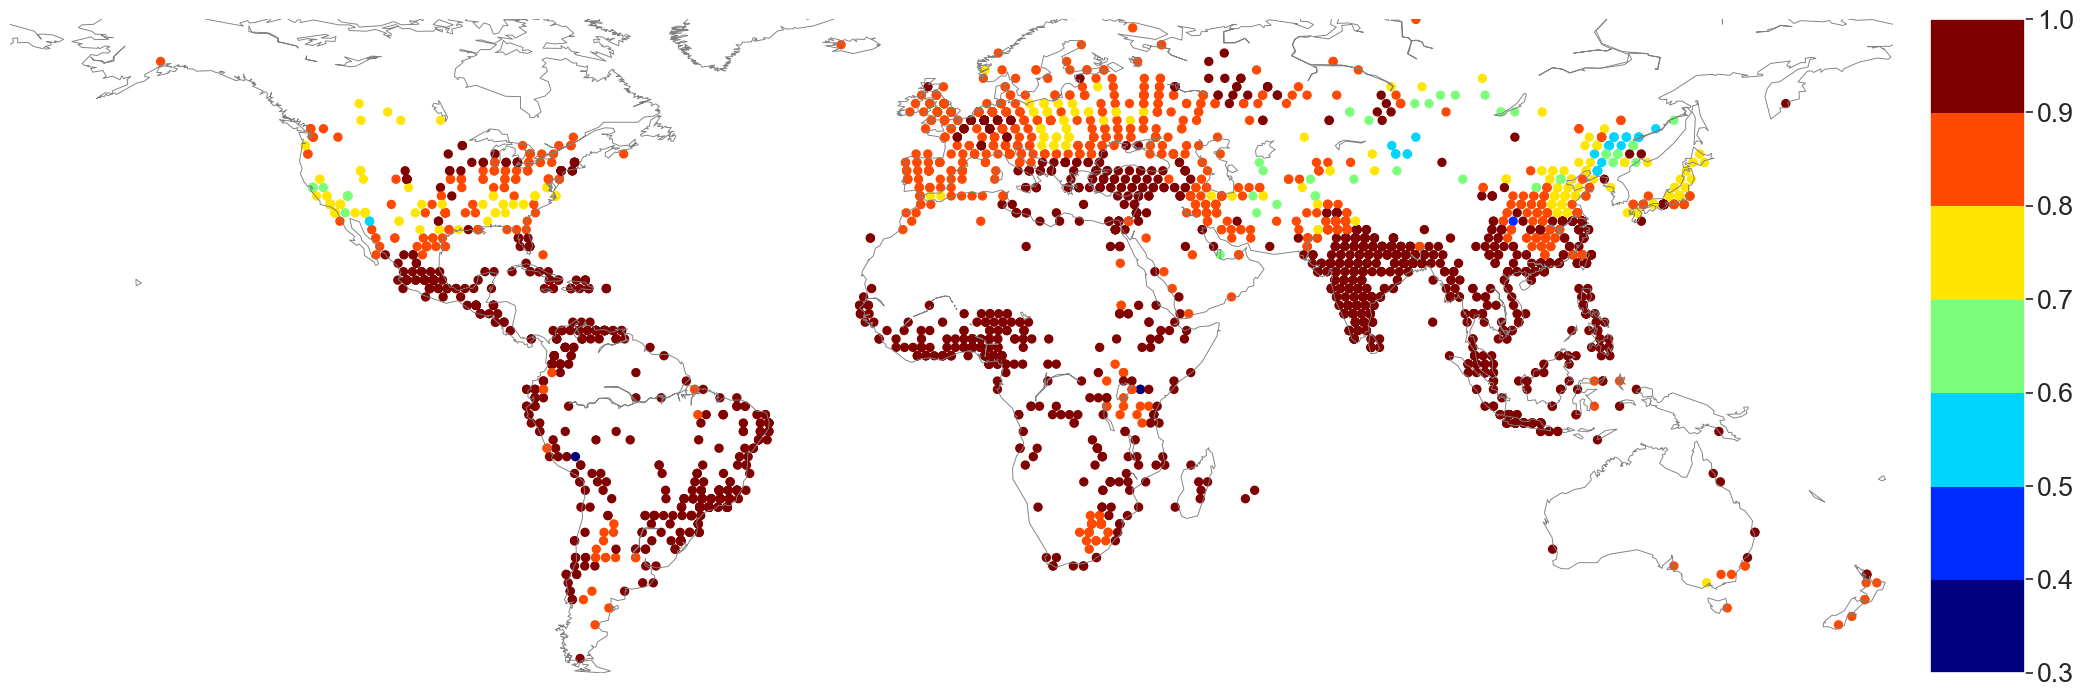

In [112]:
# Set the dimension of the figure
df = dff
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-55,urcrnrlon=180,urcrnrlat=70)
m.drawmapboundary(fill_color='white', linewidth=0)
#m.fillcontinents(color='#99ffff', alpha=0.3)
m.drawcoastlines(linewidth=0.7, color="grey")
# Add a point per position
#df90 = df.drop_duplicates(subset='val', keep='first')
cmap = plt.cm.get_cmap("jet", 7)
m.scatter(df['lon'].astype(float), df['lat'].astype(float), vmin=0.3, vmax=1,  alpha=1, c=df['val'], cmap=cmap)
cb = m.colorbar()
cb.ax.tick_params(labelsize=20)
plt.show()

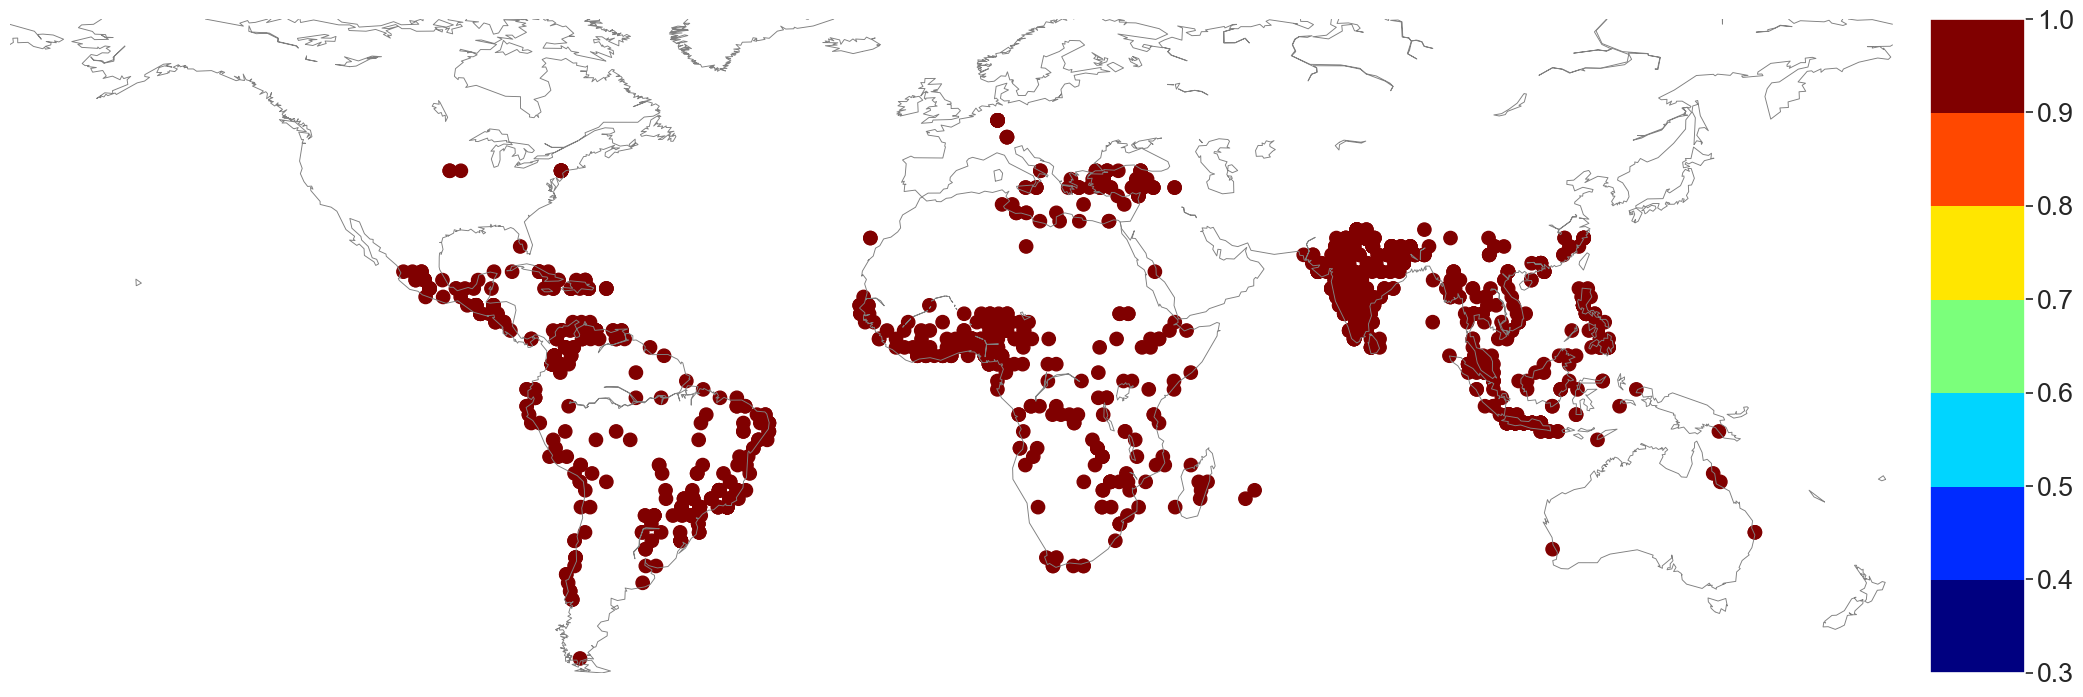

In [113]:
# now just plot the values over the 75% 
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-55,urcrnrlon=180,urcrnrlat=70)
m.drawmapboundary(fill_color='white', linewidth=0)
#m.fillcontinents(color='#99ffff', alpha=0.3)
m.drawcoastlines(linewidth=0.7, color="grey")
# Add a point per position
df90 = df.copy()
#df90 = df90.drop_duplicates(subset='val', keep='first')
df90[df90['val']<np.percentile(df90['val'],75)]=np.nan
cmap = plt.cm.get_cmap("jet", 7)
m.scatter(df90['lon'].astype(float), df90['lat'].astype(float), s=100, alpha=1, vmin=0.3, vmax=1, c=df90['val'], cmap=cmap)
cb = m.colorbar()
cb.ax.tick_params(labelsize=20)
plt.show()

In [167]:
co2 = pd.read_csv('export_20200616_0944.csv',sep=";", header=1)
co2.head()

,Unnamed: 0,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,1960,0.41388,2.0225,6.1512,NaN,0.54895,NaN,0.036640,48.7645,7.2021,...,4.3145,43.7171,NaN,57.0168,7.4839,NaN,NaN,3.6310,4.3553,5.9431
1,1961,0.4908,2.2790,6.0559,NaN,0.45371,NaN,0.047632,51.1267,7.4316,...,4.1168,45.1325,NaN,51.8798,7.9783,NaN,NaN,2.6637,3.7090,5.0613
2,1962,0.68859,2.4622,5.6610,NaN,1.17910,NaN,0.102590,53.6401,7.8061,...,4.0069,47.4259,0.040304,54.0561,9.3377,NaN,NaN,3.8838,3.5827,4.8890
3,1963,0.70674,2.0812,5.4192,NaN,1.14970,NaN,0.084272,50.0327,8.3768,...,4.3148,50.9566,0.032976,56.1517,9.1104,NaN,NaN,2.9165,3.4445,4.7004
4,1964,0.83855,2.0152,5.6430,NaN,1.22290,NaN,0.091600,55.6700,8.9131,...,4.5527,54.2875,0.062288,56.5500,11.7878,NaN,NaN,3.6310,3.2750,4.4691


In [47]:
#plt.plot(co2[''],co2['Germany'])

In [48]:

#co2.rename(columns={co2.columns[0]: "year"}, inplace=True)
meann = co2.mean()
meann.index

Index(['Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia',
       ...
       'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam',
       'Wallis and Futuna Islands', 'Western Sahara', 'Yemen', 'Zambia',
       'Zimbabwe'],
      dtype='object', length=220)

In [49]:
#year='1990'
#countries = co2.loc[co2['year']==year].columns[1:]
countries = meann.index

In [50]:
#co2_vals = co2.loc[co2['year']==year].values[0].astype(float)[1:]
co2_vals = meann

In [51]:
data1 = {'country':countries,"co2":co2_vals}
co2_df = pd.DataFrame(data1)

In [52]:
co2_df.head()

,country,co2
Albania,Albania,4.438517
Algeria,Algeria,71.259337
Andorra,Andorra,0.486066
Angola,Angola,11.225937
Anguilla,Anguilla,0.109798


In [53]:
lon_lat = pd.read_csv('contries_lon_lat.csv', sep="\t", header=None)

In [54]:
lon_lat.columns = ['abri','lon','lat','country']
lon_lat.head()
lon_lat.loc[lon_lat['country']=='United States','country']='United States of America'

In [55]:
co2_final = co2_df.join(lon_lat.set_index('country'), on='country')
lon_lat[lon_lat['country']=='United States of America']
#co2_final[co2_final['country']=='United States of America']

,abri,lon,lat,country
227,US,37.09024,-95.712891,United States of America


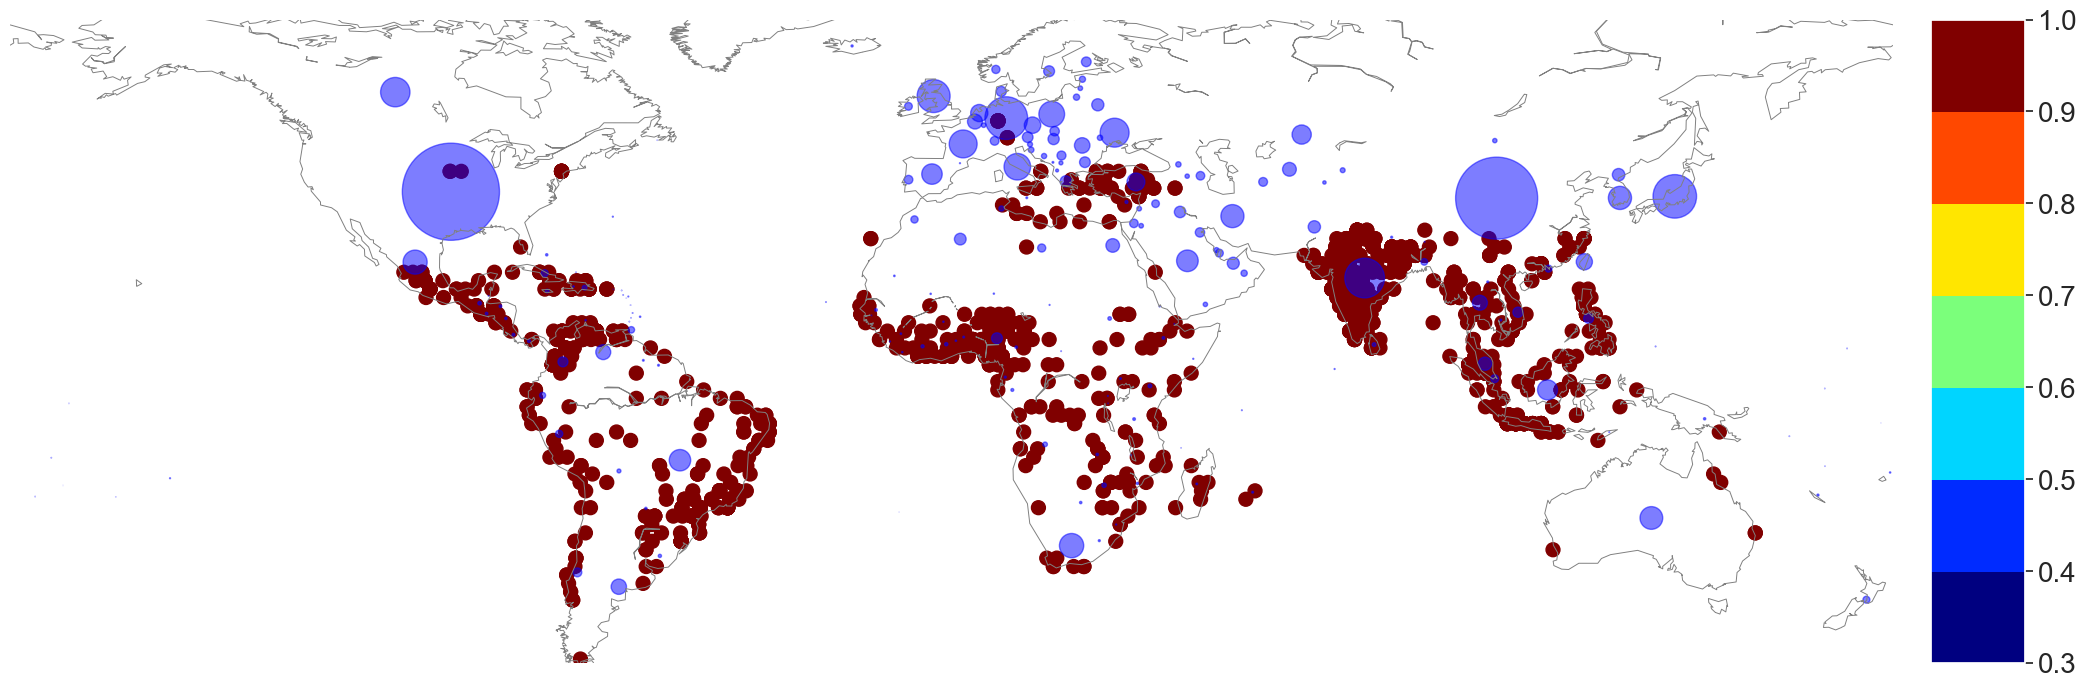

In [144]:
# now just plot the values over the 75% 
my_dpi=100
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-53,urcrnrlon=180,urcrnrlat=70)
m.drawmapboundary(fill_color='white', linewidth=0)
#m.fillcontinents(color='#99ffff', alpha=0.3)
m.drawcoastlines(linewidth=0.7, color="grey")
# Add a point per position
#df90 = df.copy()
#df90[df90['val']<np.percentile(df90['val'],99)]=np.nan


cmap = plt.cm.get_cmap("jet", 7)
m.scatter(df90['lon'].astype(float), df90['lat'].astype(float), s=100, alpha=1, vmin=0.3, vmax=1, c=df90['val'], cmap=cmap)
cb = m.colorbar()
cb.ax.tick_params(labelsize=20)
m.scatter(co2_final['lat'].astype(float), co2_final['lon'].astype(float),  alpha=.51,s=co2_final['co2'],  c='blue')


plt.show()

In [57]:
co2_final.sort_values(by=['co2'],  ascending=False)[:20]

,country,co2,abri,lon,lat
United States of America,United States of America,4894.054590,US,37.090240,-95.712891
China,China,3489.750508,CN,35.861660,104.195397
Russian Federation,Russian Federation,1692.673639,NaN,NaN,NaN
Japan,Japan,982.931917,JP,36.204824,138.252924
Germany,Germany,946.764807,DE,51.165691,10.451526
India,India,817.259347,IN,20.593684,78.962880
United Kingdom,United Kingdom,564.572924,GB,55.378051,-3.435973
Canada,Canada,448.421812,CA,56.130366,-106.346771
Ukraine,Ukraine,434.533593,UA,48.379433,31.165580
France,France,404.372810,FR,46.227638,2.213749


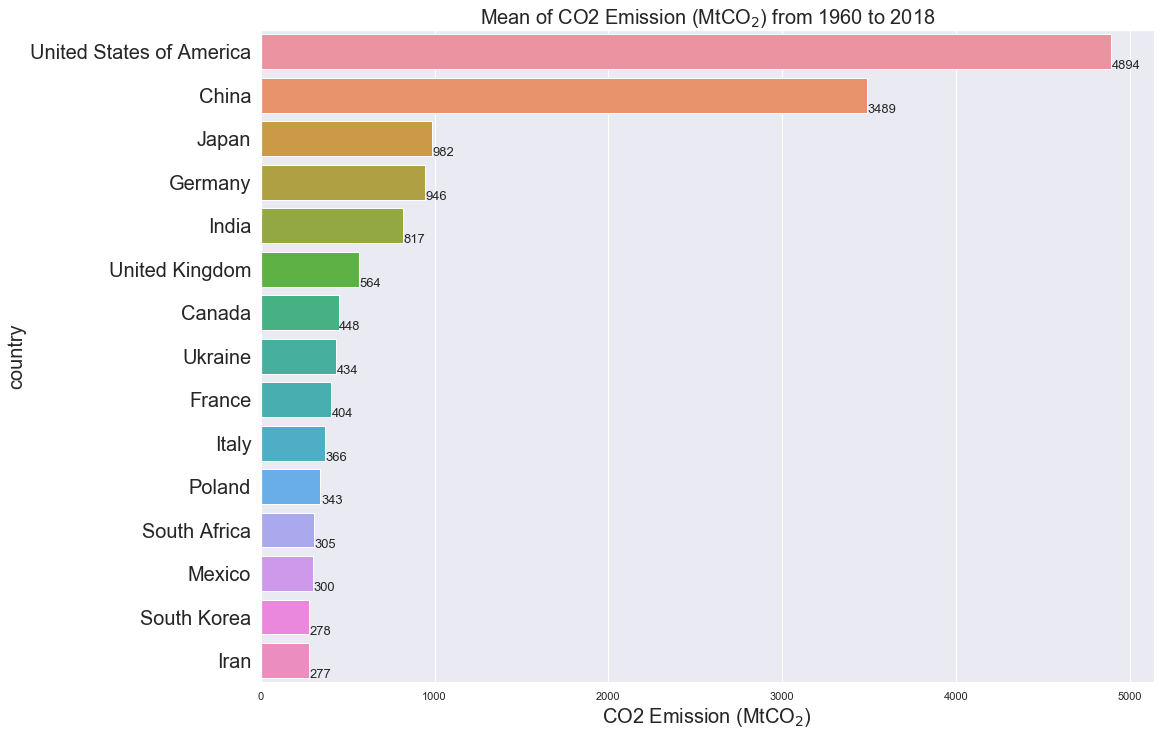

In [58]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set_color_codes("pastel")

f, ax = plt.subplots(figsize=(16, 12))
co2_final.dropna(inplace=True)
ax = sns.barplot(x='co2', y='country',  data=co2_final.sort_values(by=['co2'],  ascending=False)[:15], saturation=0.8)
plt.xlabel('CO2 Emission (MtCO$_2$)', fontsize=20)

# add annotations
[ax.text(p.get_width() + 3, p.get_y() + p.get_height(),
         int(p.get_width()), fontsize=13)
 for p in ax.patches]
ax.set_ylabel("country",fontsize=20)
#ax.set_yticklabels(ax.get_ytickslabels(), size = 15)
_, ylabels = plt.yticks()
ax.set_yticklabels(ylabels, size=20)
plt.title('Mean of CO2 Emission (MtCO$_2$) from 1960 to 2018',fontsize=20)
plt.show()

In [59]:
# plot extrems: 

#df90 = df.copy()
#df90[df90['val']<np.percentile(df90['val'],99)]=np.nan
df90.dropna(inplace=True)
df90.sort_values(by=['val'],  ascending=False)[:20]

,City,val,lon,lat
4,Sukabumi,0.916597,106.22,-7.23
0,Krefeld,0.915763,6.34,50.63
2,Bahir Dar,0.914929,37.81,12.05
159,Latina,0.914095,12.78,40.99
101,Burgas,0.913261,28.36,42.59
56,Texcoco,0.912427,-98.96,20.09
553,Elbasan,0.911593,19.17,40.99
100,Lilongwe,0.910759,33.85,-13.66
41,Araras,0.909925,-47.60,-21.70
99,Beni Suef,0.909091,31.38,29.74


 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.8990825688073395
 ------------------------------------------------------------------------------------------- 


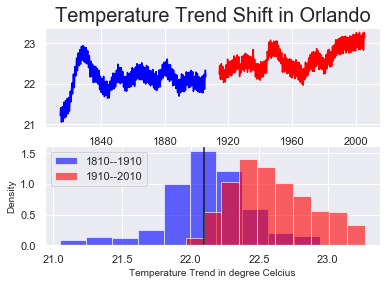

In [120]:
df = pd.read_csv('df_cor_dupli.csv')
plots_stats(df, city="Orlando")

## The eight robbers of the "casa de papel" : 
- `Tokyo`
- `Moscow`
- `Berlin`
- `Nairobi`
- `Rio`
- `Denver`
- `Helsinki`
- `Oslo`


 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7331109257714762
 ------------------------------------------------------------------------------------------- 


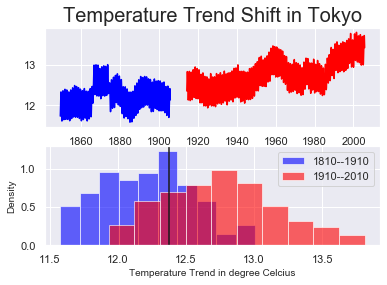

In [153]:
plots_stats(df, city="Tokyo")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7631359466221852
 ------------------------------------------------------------------------------------------- 


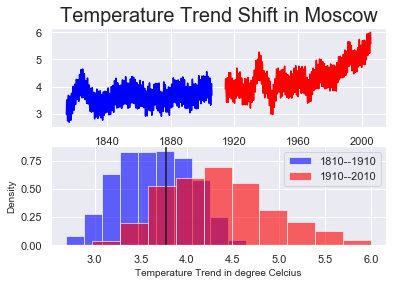

In [80]:
my_dpi=100
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
plots_stats(df, city="Moscow")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.9057547956630525
 ------------------------------------------------------------------------------------------- 


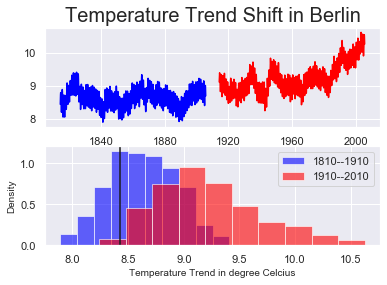

In [81]:
plots_stats(df, city="Berlin")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.04420350291909925
 ------------------------------------------------------------------------------------------- 


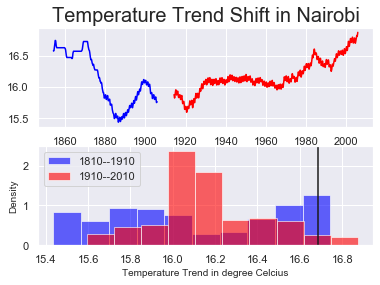

In [82]:
plots_stats(df, city="Nairobi")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.8348623853211009
 ------------------------------------------------------------------------------------------- 


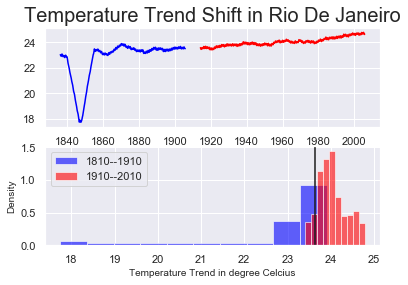

In [85]:
plots_stats(df, city="Rio De Janeiro")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.9007506255212677
 ------------------------------------------------------------------------------------------- 


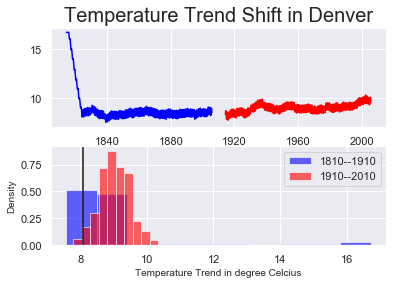

In [86]:
plots_stats(df, city="Denver")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.817347789824854
 ------------------------------------------------------------------------------------------- 


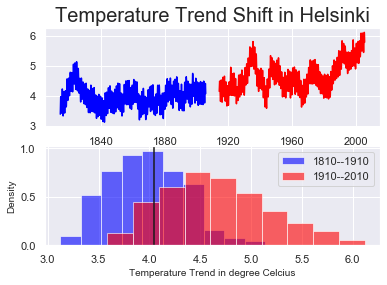

In [87]:
plots_stats(df, city="Helsinki")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.786488740617181
 ------------------------------------------------------------------------------------------- 


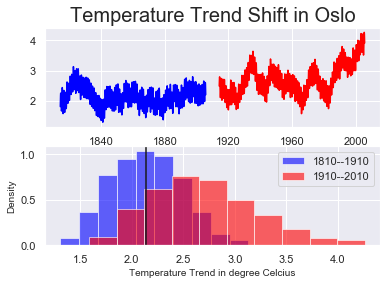

In [88]:
plots_stats(df, city="Oslo")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7731442869057548
 ------------------------------------------------------------------------------------------- 


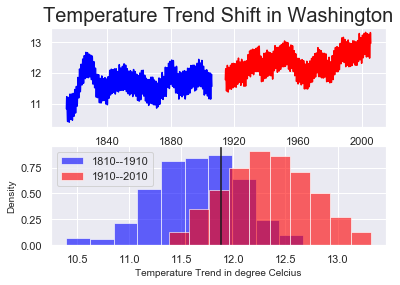

In [121]:
plots_stats(df, city="Washington")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.9032527105921602
 ------------------------------------------------------------------------------------------- 


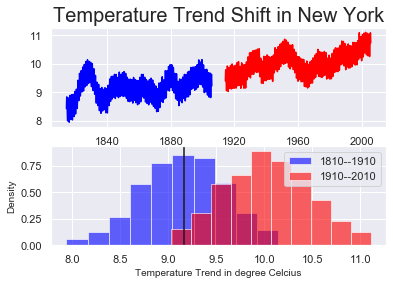

In [122]:
plots_stats(df, city="New York")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.8924103419516264
 ------------------------------------------------------------------------------------------- 


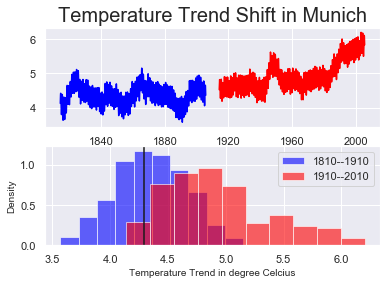

In [123]:
plots_stats(df, city="Munich")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.8498748957464554
 ------------------------------------------------------------------------------------------- 


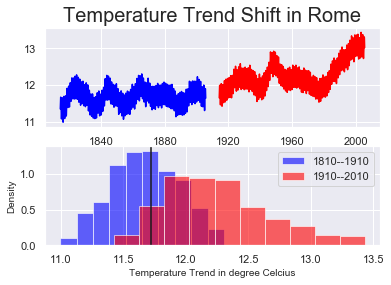

In [130]:
plots_stats(df, city="Rome")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7331109257714762
 ------------------------------------------------------------------------------------------- 


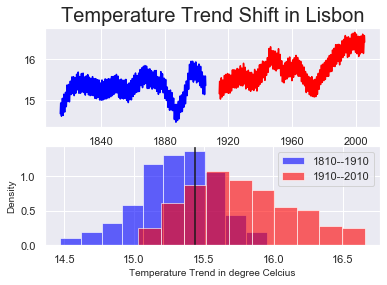

In [135]:
plots_stats(df, city="Lisbon")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.8698915763135947
 ------------------------------------------------------------------------------------------- 


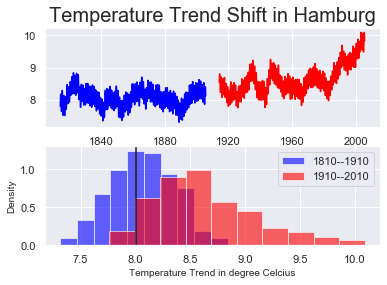

In [136]:
plots_stats(df, city="Hamburg")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7447873227689742
 ------------------------------------------------------------------------------------------- 


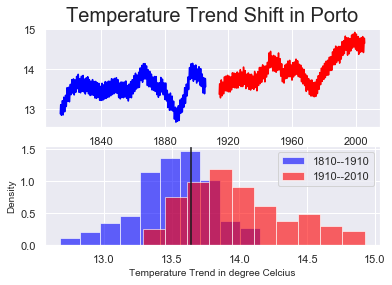

In [137]:
plots_stats(df, city="Porto")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7781484570475397
 ------------------------------------------------------------------------------------------- 


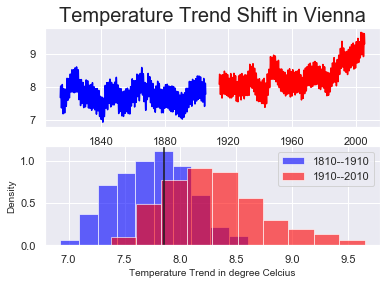

In [138]:
plots_stats(df, city="Vienna")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.890742285237698
 ------------------------------------------------------------------------------------------- 


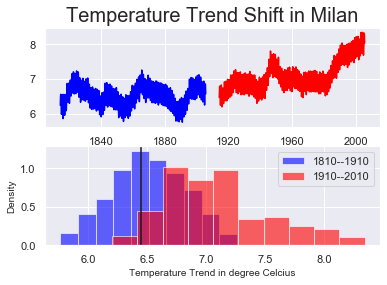

In [139]:
plots_stats(df, city="Milan")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.7589658048373644
 ------------------------------------------------------------------------------------------- 


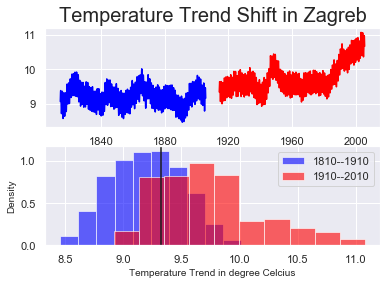

In [140]:
plots_stats(df, city="Zagreb")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.908256880733945
 ------------------------------------------------------------------------------------------- 


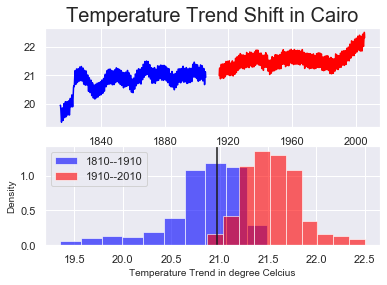

In [141]:
plots_stats(df, city="Cairo")

 ------------------------------------------------------------------------------------------- 
 ------------------------------------------------------------------------------------------- 
this much of the recent climate is greater than the past climate :  0.9165971643035863
 ------------------------------------------------------------------------------------------- 


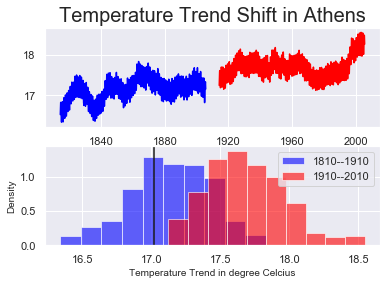

In [142]:
plots_stats(df, city="Athens")

## Now plot worlds flight data : 
**Air transport, passengers carried**
Air passengers carried include both domestic and international aircraft passengers of air carriers registered in the country.

for download and more info : 

https://data.worldbank.org/indicator/IS.AIR.PSGR?end=2018&start=2018&type=points&view=map&year=2018

In [186]:
flight = pd.read_csv('API_IS/API_IS.AIR.PSGR_DS2_en_csv_v2_1120890.csv',sep=",", header=2)

In [187]:
flight.head()


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 64
0,Aruba,ABW,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,223502.0,274280.00,NaN,NaN
1,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,2.279341e+06,1.737962e+06,2044188.0,2209428.0,1929907.0,1917924.0,1647425.0,1722612.61,NaN,NaN
2,Angola,AGO,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,9.877980e+05,1.132424e+06,1321872.0,1409952.0,1244491.0,1482546.0,1375523.0,1516628.00,NaN,NaN
3,Albania,ALB,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,8.297789e+05,8.143397e+05,865848.0,151632.0,NaN,26634.0,204090.0,303137.00,NaN,NaN
4,Andorra,AND,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
meann = np.nanmean(flight.iloc[:,5:], axis=1)
#print(meann)
#year = meann.index
countries = flight['Country Name']
data1 = {'country':countries,"air transport":meann}
flight_df = pd.DataFrame(data1)

In [198]:
flight_df.head()

,country,air transport
0,Aruba,248891.000000
1,Afghanistan,559205.497898
2,Angola,639208.720930
3,Albania,252707.152256
4,Andorra,NaN


In [202]:
flight_final = flight_df.join(lon_lat.set_index('country'), on='country')
#flight_final.sort_values(by=['air transport'],  ascending=False)[:15]
flight_final.head()
#flight_final.sort_values(by=['air transport'],  ascending=False)[:15]


,country,air transport,abri,lon,lat
257,World,1.541016e+09,NaN,NaN,NaN
93,High income,1.091486e+09,NaN,NaN,NaN
179,OECD members,1.055276e+09,NaN,NaN,NaN
196,Post-demographic dividend,1.001510e+09,NaN,NaN,NaN
63,Europe & Central Asia,5.674369e+08,NaN,NaN,NaN
168,North America,5.430281e+08,NaN,NaN,NaN
249,United States,5.085272e+08,NaN,NaN,NaN
101,IDA & IBRD total,4.729659e+08,NaN,NaN,NaN
138,Low & middle income,4.595271e+08,NaN,NaN,NaN
154,Middle income,4.520159e+08,NaN,NaN,NaN


In [174]:
flight_final.head()

,country,air transport,abri,lon,lat
0,Aruba,NaN,AW,12.521110,-69.968338
1,Afghanistan,NaN,AF,33.939110,67.709953
2,Angola,NaN,AO,-11.202692,17.873887
3,Albania,NaN,AL,41.153332,20.168331
4,Andorra,NaN,AD,42.546245,1.601554


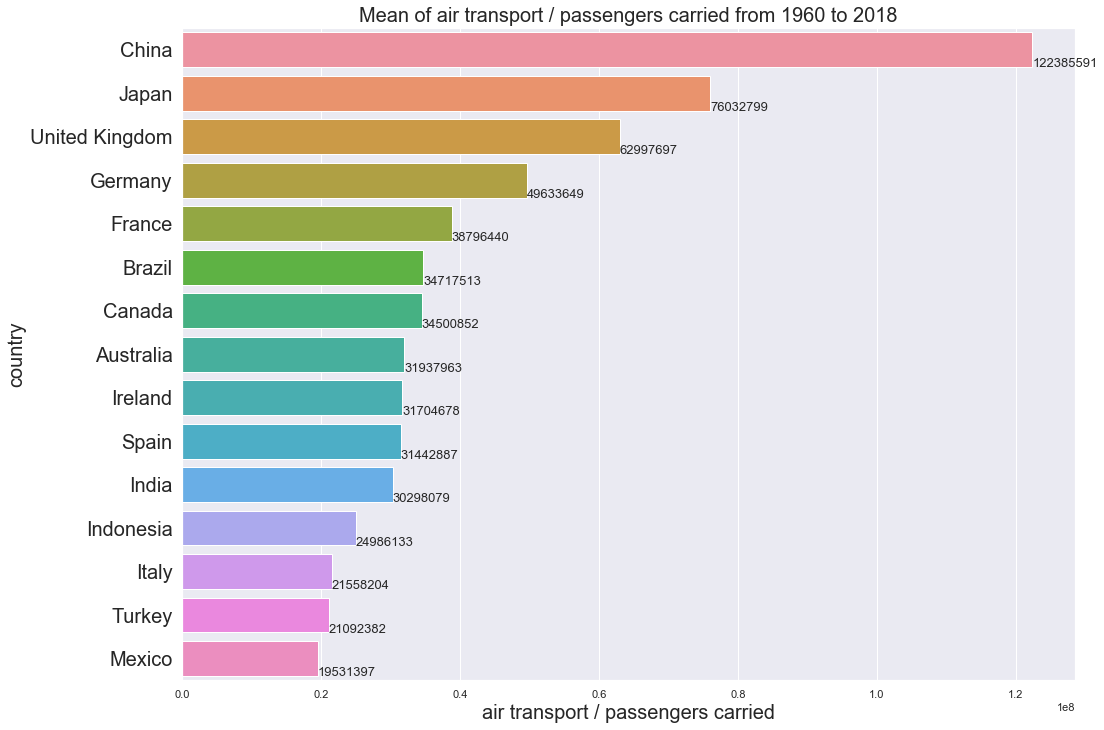

In [203]:
sns.set(style="darkgrid")
sns.set_color_codes("pastel")

f, ax = plt.subplots(figsize=(16, 12))
flight_final.dropna(inplace=True)
ax = sns.barplot(x='air transport', y='country',  data=flight_final.sort_values(by=['air transport'],  ascending=False)[:15], saturation=0.8)
plt.xlabel('air transport / passengers carried', fontsize=20)

# add annotations
[ax.text(p.get_width() + 3, p.get_y() + p.get_height(),
         int(p.get_width()), fontsize=13)
 for p in ax.patches]
ax.set_ylabel("country",fontsize=20)
#ax.set_yticklabels(ax.get_ytickslabels(), size = 15)
_, ylabels = plt.yticks()
ax.set_yticklabels(ylabels, size=20)
plt.title('Mean of air transport / passengers carried from 1960 to 2018',fontsize=20)
plt.show()